In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [180]:
import pandas as pd
import geopandas as gpd
import mscthesis
import plotly.graph_objects as pgo
import plotly.express as px
import validation
import plots
import pipeline
import models

In [200]:
cfg = pipeline.Config(
    visit_factory=models.VisitsFromFile(file_path='./../../dbs/sweden/visits-song.csv'),
    home_locations_path='./../../dbs/sweden/homelocations.csv',
    gravity_model=validation.GravityModel(beta=0.03),
)

In [201]:
cfg.describe()

{'visits': {'type': 'from_file', 'path': './../../dbs/sweden/visits-song.csv'},
 'home_locations': './../../dbs/sweden/homelocations.csv',
 'gravity_model': {'beta': 0.03, 'max_iter': 5000, 'tolerance': 1e-08}}

In [207]:
pipe = pipeline.Pipeline()
pipe.prepare()

In [210]:
res = pipe.run(cfg)

reading home_locations
Converting visits to GeoDataFrame...
Converting CRS...
scoring on national scale...
aligning visits...
Not bboxing national
Aligning region-visits to Sampers zones...
removed 154224 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
removed 12185 point-visits due to missing zone geom
1759991 visits left after alignment
Creating ODM...
IPF converged after 320 iterations
scoring on east scale...
aligning visits...
removed 1009680 visits due to sampling bbox
Aligning region-visits to Sampers zones...
removed 79346 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
removed 5746 point-visits due to missing zone geom
831628 visits left after alignment
Creating ODM...
IPF converged after 400 iterations
scoring on west scale...
aligning visits...
removed 1563520 visits due to sampling bbox
Aligning region-visits to Sampers zones...
removed 25844 region-visits due to missing zone geom
Aligning point-visits to Sam

In [226]:
scale = 'west'

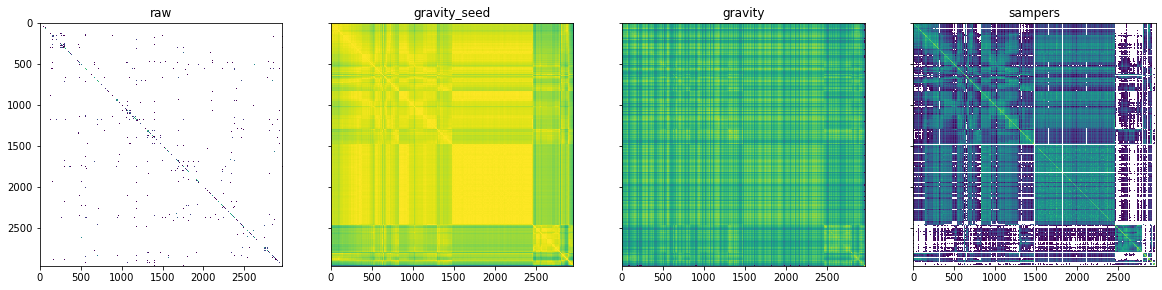

In [223]:
_ = plots.plot_odms(
    [
        res.sparse_odms[scale],
        res.seed_odms[scale],
        res.dense_odms[scale],
        pipe.sampers.odm[scale]
    ], 
    ['raw', 'gravity_seed', 'gravity', 'sampers'],
)

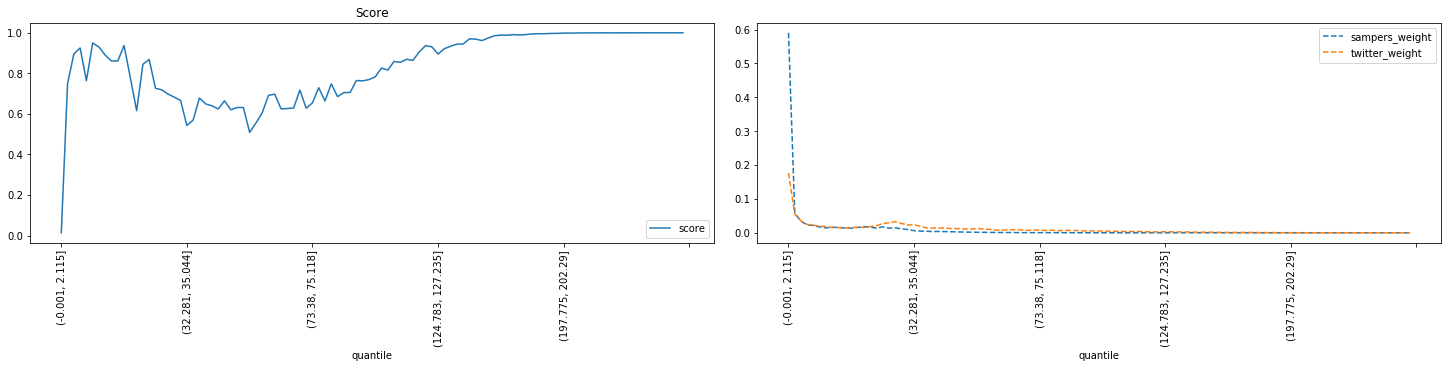

In [275]:
_ = plots.plot_spssim_score(res.spssim_scores[scale])

In [233]:
dm = validation.DistanceMetrics()

In [236]:
distance_metrics = dm.compute(
    pipe.sampers.quantile_groups[scale], 
    [
       res.sparse_odms[scale],
        res.seed_odms[scale],
        res.dense_odms[scale],
        pipe.sampers.odm[scale] 
    ],
    ['model', 'gravity_seed', 'gravity', 'sampers'],
)

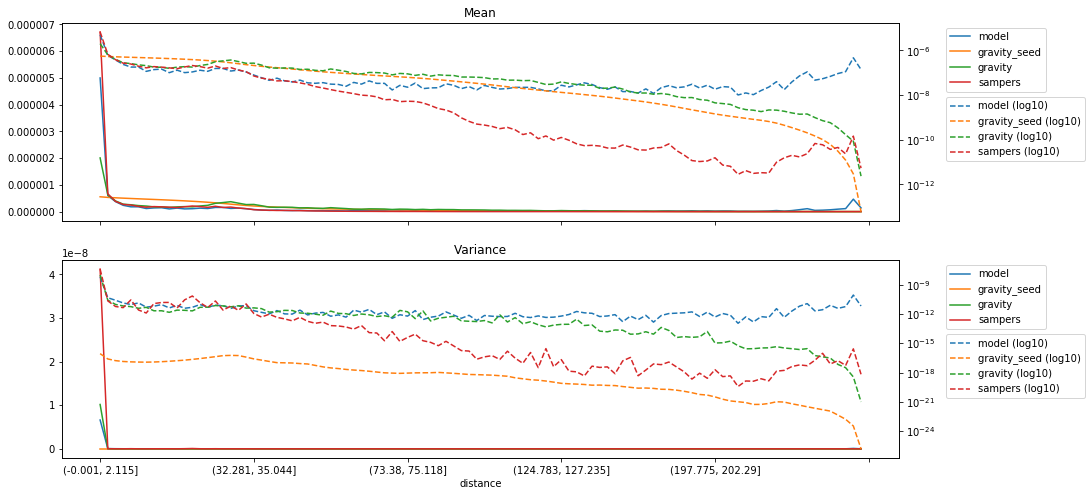

In [278]:
_ = plots.plot_distance_metrics(distance_metrics, ['model', 'gravity_seed', 'gravity', 'sampers'])

In [4]:
visits = pd.read_csv('./../../dbs/sweden/visits-song.csv').set_index('userid')
home_locations = pd.read_csv('./../../dbs/sweden/homelocations.csv').set_index('userid')
home_locations = gpd.GeoDataFrame(
    home_locations,
    crs="EPSG:3006",
    geometry=gpd.points_from_xy(home_locations.x, home_locations.y),
)

In [133]:
sampers = validation.Sampers()
sampers.prepare()

Preparing scale national
Reading original data...
zones (682, 2)
odm (595984,) 221892.04955949992
Reindexing...
odm (465124,)
Calculating distances between zones...
distances (465124,)
Calculating quantiles...

Preparing scale east
Reading original data...
zones (3038, 5)
odm (9253764,) 4982573.000714299
Reindexing...
odm (9229444,)
Calculating distances between zones...
distances (9229444,)
Calculating quantiles...

Preparing scale west
Reading original data...
zones (2964, 5)
odm (8791225,) 3339597.621275899
Reindexing...
odm (8785296,)
Calculating distances between zones...
distances (8785296,)
Calculating quantiles...



In [134]:
sampers.quantile_groups["national"]

In [6]:
converted_visits = sampers.convert(visits)

Converting visits to GeoDataFrame...
Converting CRS...


In [28]:
scale = "east"

In [29]:
sparse_odm = sampers.align(scale, converted_visits, home_locations)

removed 1009680 visits due to sampling bbox
Aligning region-visits to Sampers zones...
removed 79346 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
removed 5746 point-visits due to missing zone geom
831628 visits left after alignment
Creating ODM...


In [30]:
sparse_odm = sampers.distance_cut(scale, sparse_odm)

In [152]:
gm = validation.GravityModel(beta=0.03)
gm.describe()

{'beta': 0.03, 'max_iter': 5000, 'tolerance': 1e-08}

In [161]:
seed = gm.seed(sampers.distances[scale])

In [162]:
dense_odm = gm.gravitate(sparse_odm, seed)

IPF converged after 400 iterations


In [163]:
dense_odm = sampers.distance_cut(scale, dense_odm)

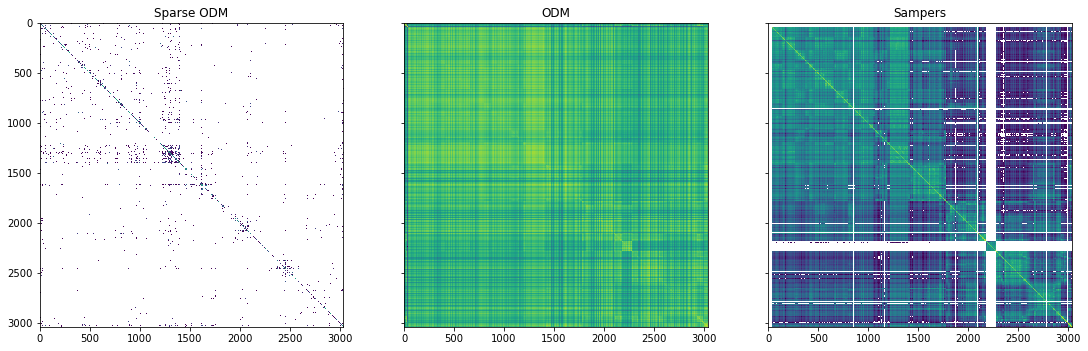

In [164]:
_ = plots.plot_odms(sparse_odm, dense_odm, sampers.odm[scale])

In [136]:
spssim = validation.SPSSIM()

In [137]:
score = spssim.score(sampers.odm[scale], dense_odm, sampers.quantile_groups[scale])

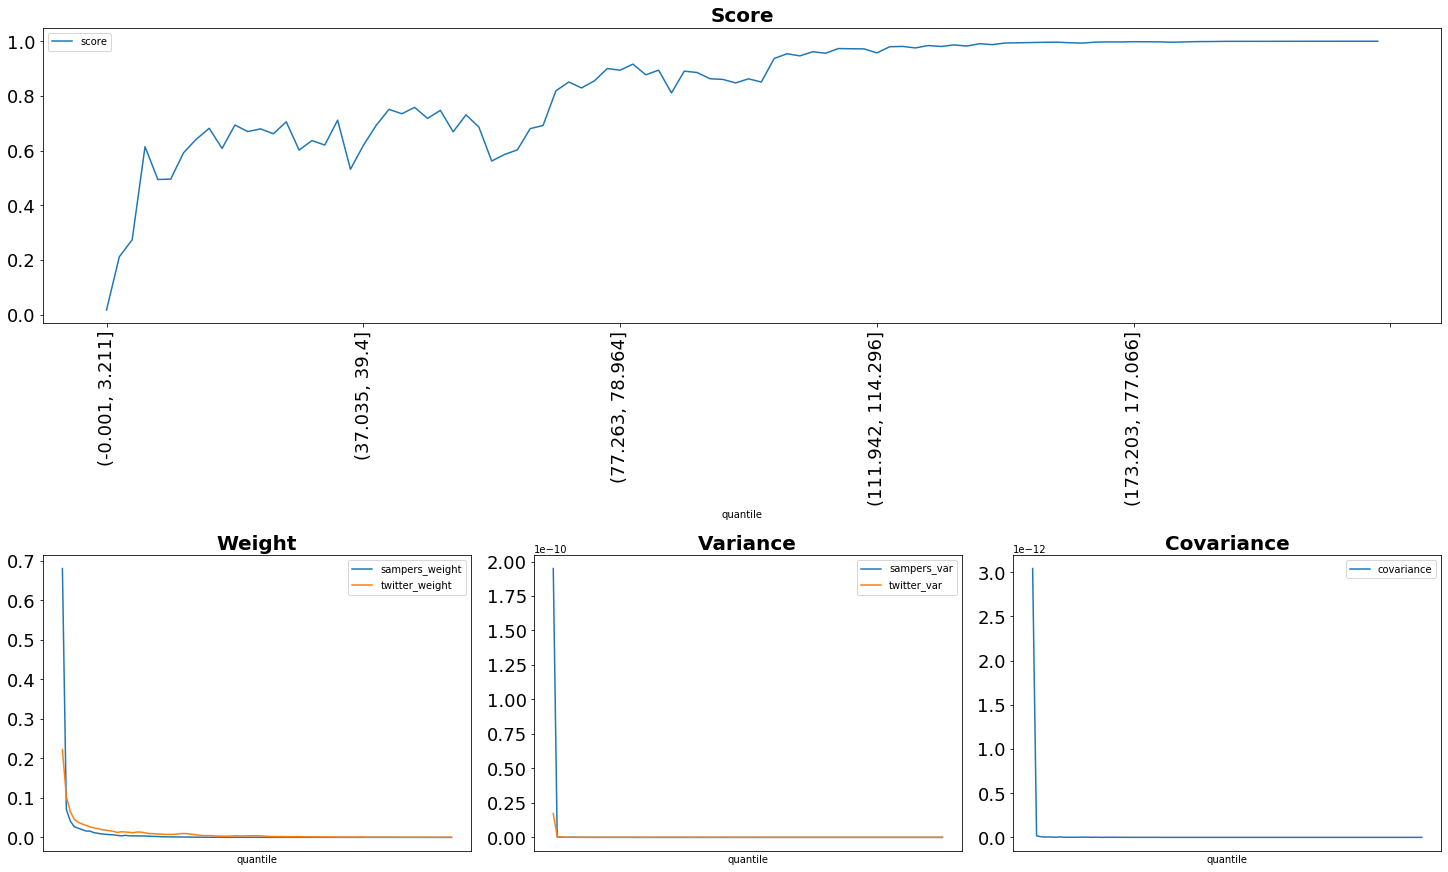

In [138]:
_ = plots.plot_spssim_score(score)

In [141]:
(score.score * score.twitter_weight).sum()

0.45632869516344393

In [142]:
(score.score * score.sampers_weight).sum()

0.1668006545866955

In [157]:
dm = validation.DistanceMetrics()

In [165]:
metrics = dm.compute(
    sampers.quantile_groups[scale],
    [sampers.odm[scale], sparse_odm, dense_odm, seed],
    ["sampers", "model", "gravity", "gravity_seed"]
)

In [166]:
metrics

,sampers_mean,model_mean,gravity_mean,gravity_seed_mean,sampers_var,model_var,gravity_var,gravity_seed_var
distance,,,,,,,,
"(-0.001, 3.211]",7.370865e-06,5.457997e-06,2.406424e-06,5.927266e-07,1.943457e-08,8.303427e-09,1.710902e-09,2.259008e-16
"(3.211, 5.192]",7.699187e-07,7.859594e-07,1.114463e-06,5.532856e-07,2.181541e-11,3.529467e-11,5.526804e-11,9.021649e-17
"(5.192, 6.939]",4.483360e-07,4.344206e-07,7.089169e-07,5.235326e-07,1.681111e-11,1.497386e-11,3.031913e-11,6.232140e-17
"(6.939, 8.647]",2.938864e-07,2.867374e-07,4.976839e-07,4.971497e-07,4.295125e-12,6.344105e-12,4.419860e-12,5.433544e-17
"(8.647, 10.313]",2.514278e-07,2.244375e-07,4.129100e-07,4.725876e-07,1.158260e-11,5.783368e-12,4.818946e-12,4.638674e-17
...,...,...,...,...,...,...,...,...
"(277.455, 291.861]",2.954753e-12,5.048093e-08,7.098671e-10,1.242168e-10,8.587053e-22,8.228937e-13,4.302825e-17,2.370254e-22
"(291.861, 312.377]",1.933675e-12,5.196912e-08,4.337506e-10,7.546845e-11,4.315411e-22,1.055175e-12,9.734527e-18,1.756223e-22
"(312.377, 348.792]",7.672736e-13,9.569890e-08,3.343728e-10,3.462532e-11,9.650734e-23,2.208734e-12,2.809121e-18,1.032500e-22


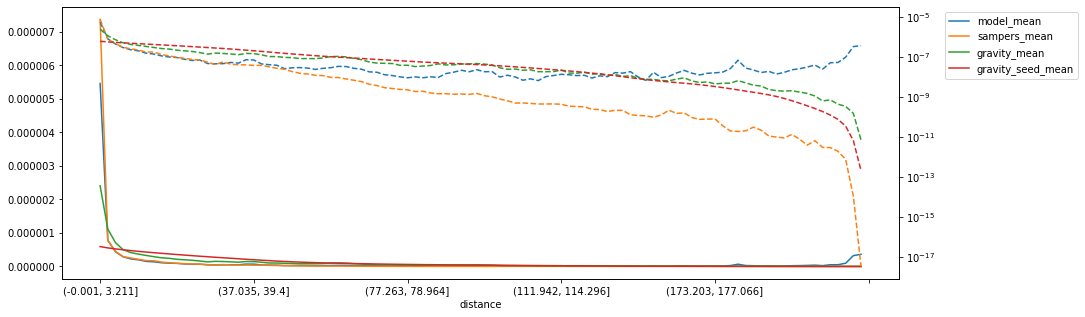

In [178]:
fig, ax1 = plt.subplots(1,1, figsize=(15,5))
metrics[['model_mean', 'sampers_mean', 'gravity_mean', 'gravity_seed_mean']].plot(ax=ax1).legend(bbox_to_anchor=(1.22, 1))
ax2 = ax1.twinx()
metrics[['model_mean', 'sampers_mean', 'gravity_mean', 'gravity_seed_mean']].plot(ax=ax2, logy=True, style='--', legend=False)

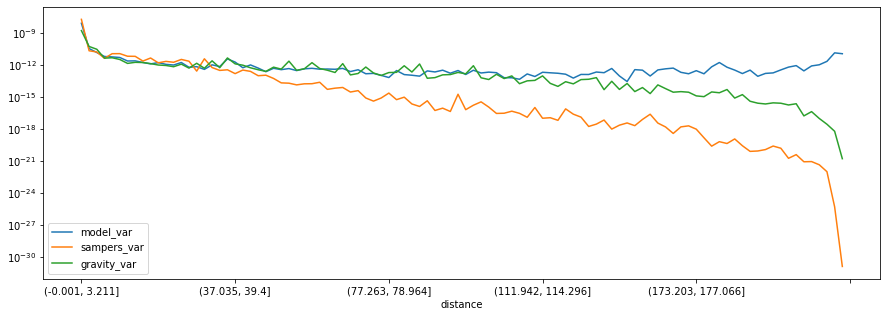

In [118]:
distance_metrics[['model_var', 'sampers_var', 'gravity_var']].plot(figsize=(15,5), logy=True)